In [40]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
tiktok = pd.read_csv("tiktok_reports.csv")
tiktok = tiktok.dropna()

In [42]:
claims = tiktok[tiktok['claim_status'] == 'claim']
opinions = tiktok[tiktok['claim_status'] == 'opinion']

In [43]:
opinions_text = opinions['video_transcription_text']
claims_text = claims['video_transcription_text']
common_words = pd.read_csv("most_common_words.csv")

In [44]:
opinions_text = opinions_text.str.split(' ')
opinions_text = opinions_text.explode().reset_index()
opinions_text = opinions_text[opinions_text['video_transcription_text'] != '']
opinions_text = pd.merge(opinions_text, common_words, left_on='video_transcription_text', right_on='word', how="outer", indicator=True).query('_merge=="left_only"')
opinions_text = opinions_text.groupby('video_transcription_text').count().sort_values(by=['index'], ascending=False)
opinions_text = opinions_text.drop(['word', '_merge'], axis=1)
opinions_text.to_csv('opinions.csv')

In [45]:
claims_text = claims_text.str.split(' ')
claims_text = claims_text.explode().reset_index()
claims_text = claims_text[claims_text['video_transcription_text'] != '']
claims_text = pd.merge(claims_text, common_words, left_on='video_transcription_text', right_on='word', how="outer", indicator=True).query('_merge=="left_only"')
claims_text = claims_text.groupby('video_transcription_text').count().sort_values(by=['index'], ascending=False)
claims_text = claims_text.drop(['word', '_merge'], axis=1)
claims_text.to_csv('claims.csv')

In [46]:
in_claims = pd.merge(claims_text, opinions_text, on=['video_transcription_text'], how="outer", indicator=True)
in_claims = in_claims[in_claims['_merge'] == 'left_only']
in_claims = in_claims.drop(['index_y', '_merge'], axis=1)
in_claims = in_claims.rename(columns={'index_x': "occurences"}).astype(int)

In [47]:
in_opinions = pd.merge(opinions_text, claims_text, on=['video_transcription_text'], how="outer", indicator=True)
in_opinions = in_opinions[in_opinions['_merge'] == 'left_only']
in_opinions = in_opinions.drop(['index_y', '_merge'], axis=1)
in_opinions = in_opinions.rename(columns={'index_x': "occurences"}).astype(int)

In [48]:
in_both = pd.merge(opinions_text, claims_text, on=['video_transcription_text'], how="outer", indicator=True)
in_both = in_both[in_both['_merge'] == 'both']
in_both = in_both.drop(['index_y', '_merge'], axis=1)
in_both.to_csv('both.csv')

In [49]:
claims_occurences = in_claims['occurences'][0:10,]
opinions_occurences = in_opinions['occurences'][0:10,]

Text(0, 0.5, 'Occurences')

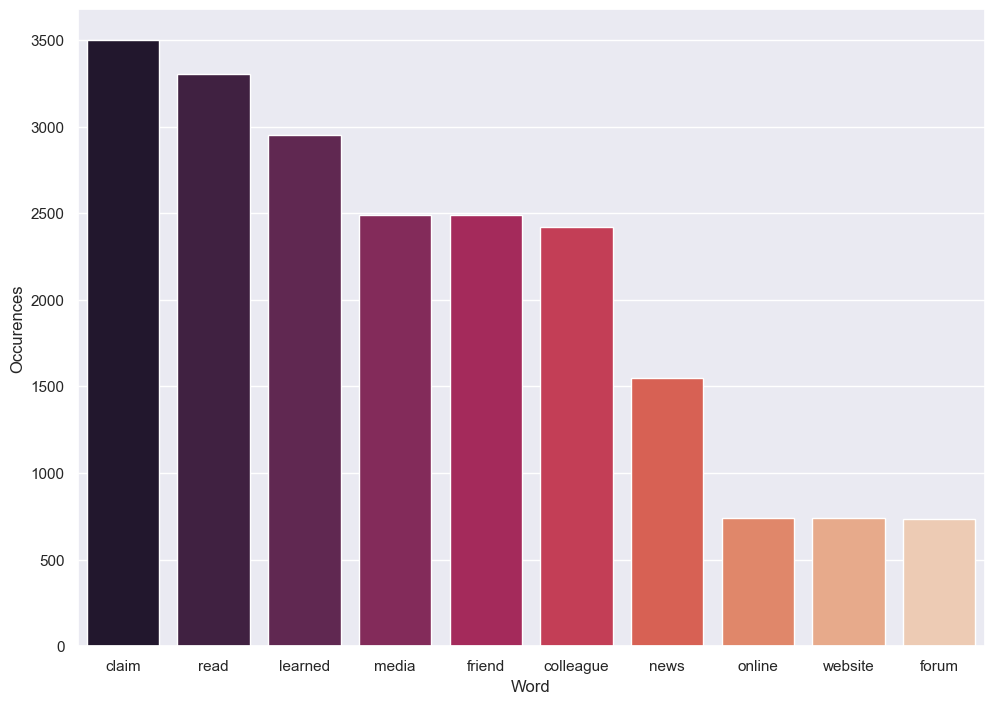

In [50]:
sns.barplot(x=claims_occurences.index, y=claims_occurences.values, hue=claims_occurences.index, palette="rocket")
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Word')
plt.ylabel('Occurences')

Text(0, 0.5, 'Occurences')

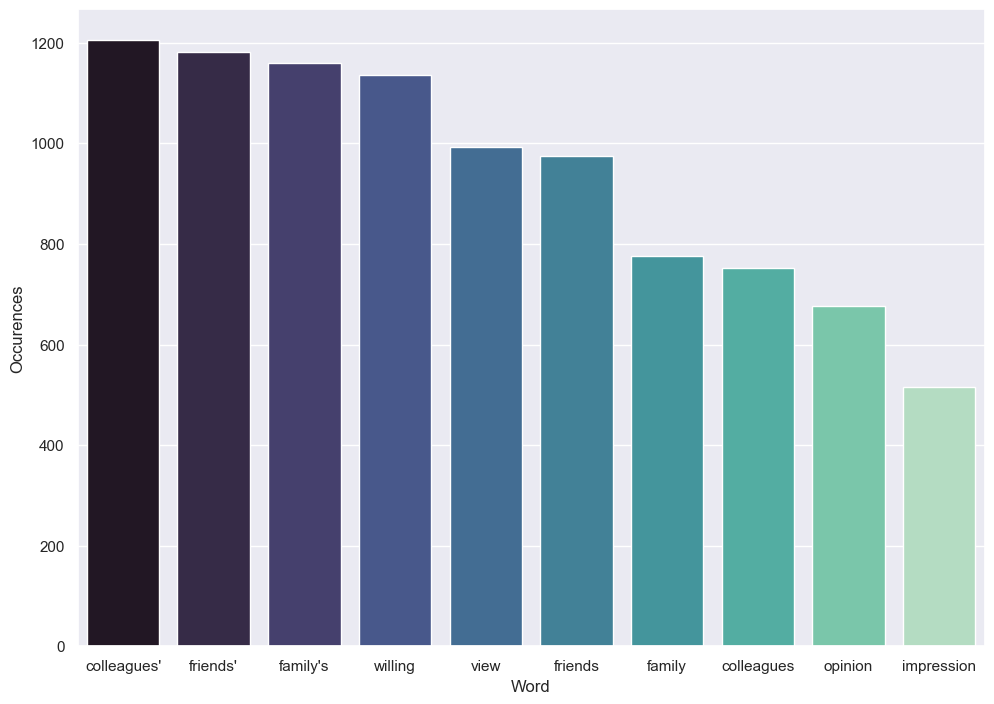

In [51]:
sns.barplot(x=opinions_occurences.index, y=opinions_occurences.values, hue=opinions_occurences.index, palette="mako")
plt.xlabel('Word')
plt.ylabel('Occurences')

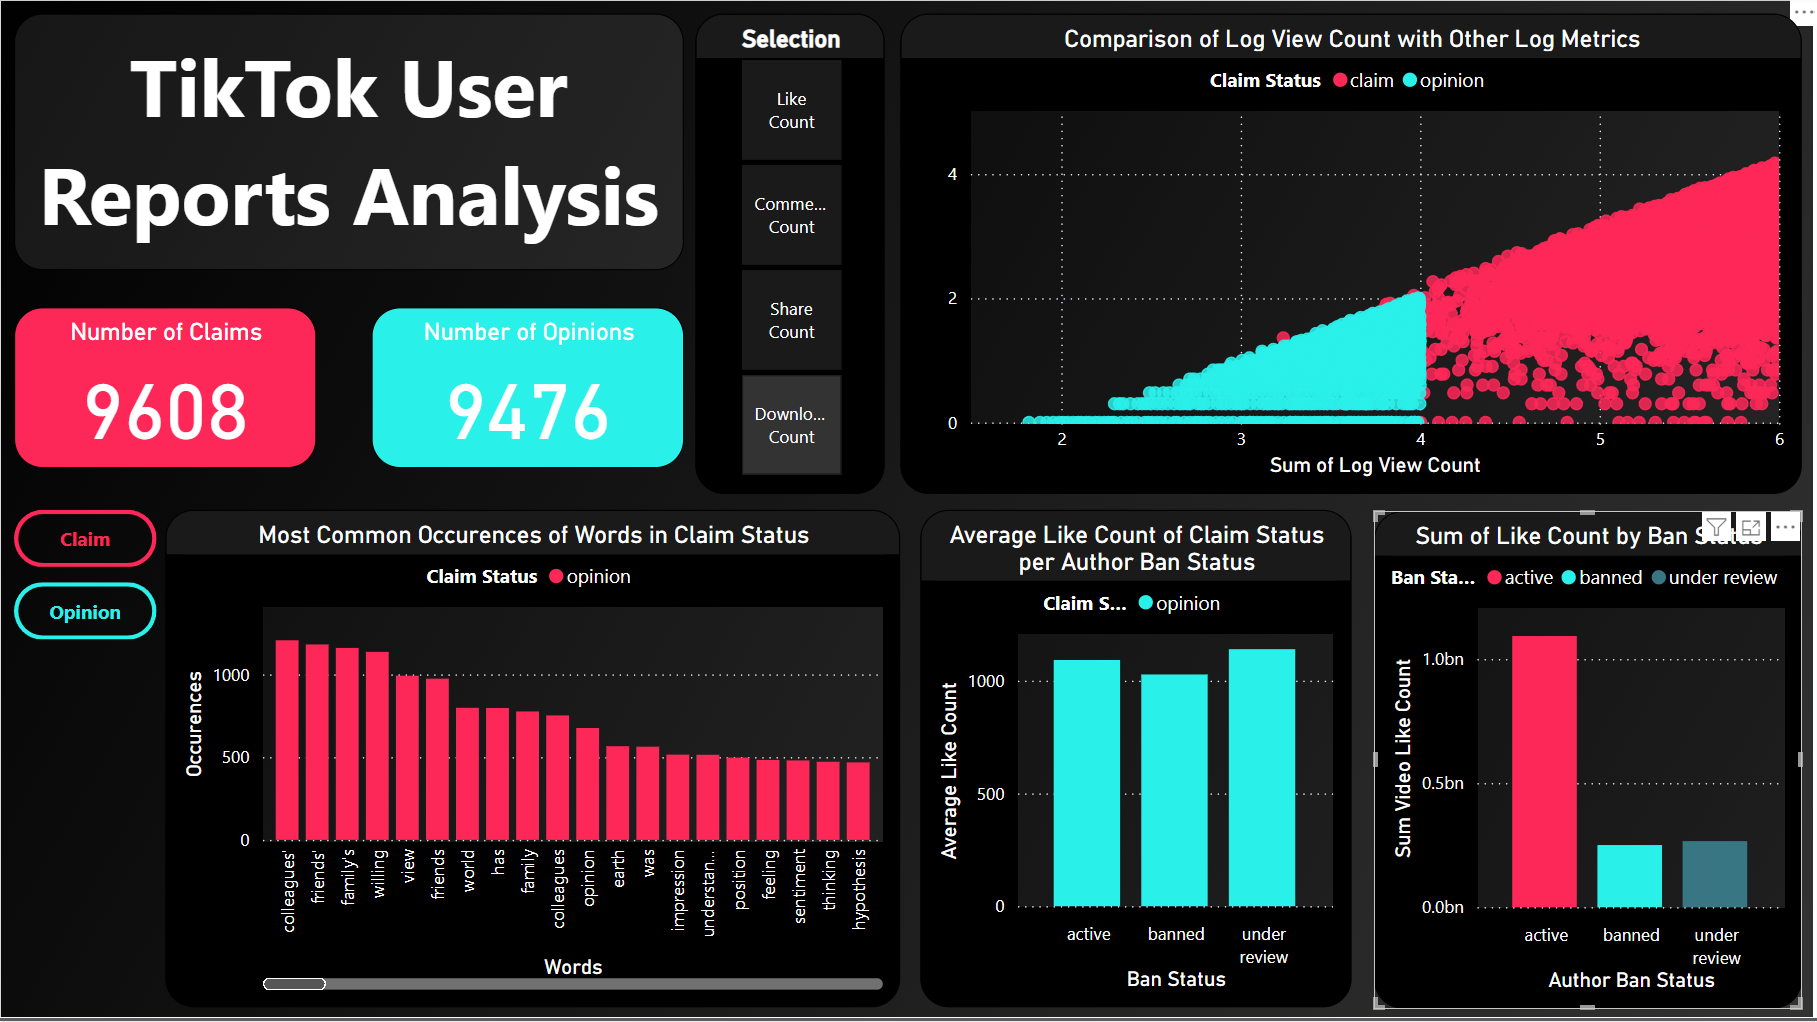

In [53]:
from IPython.display import Image
Image("tiktok_dashboard.png")
#![title](tiktok_dashboard.png)